#Transformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# informer, ARIMA, Prophet, LSTMa와는 다른 형식의 CSV를 사용한다.(Version2)

!pip install pandas


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version2.csv', encoding='cp949')
df.head()

,날짜,2021-02-01 0:00,2021-02-01 1:00,2021-02-01 2:00,2021-02-01 3:00,2021-02-01 4:00,2021-02-01 5:00,2021-02-01 6:00,2021-02-01 7:00,2021-02-01 8:00,2021-02-01 9:00,2021-02-01 10:00,2021-02-01 11:00,2021-02-01 12:00,2021-02-01 13:00,2021-02-01 14:00,2021-02-01 15:00,2021-02-01 16:00,2021-02-01 17:00,2021-02-01 18:00,2021-02-01 19:00,2021-02-01 20:00,2021-02-01 21:00,2021-02-01 22:00,2021-02-01 23:00,2021-02-02 0:00,2021-02-02 1:00,2021-02-02 2:00,2021-02-02 3:00,2021-02-02 4:00,2021-02-02 5:00,2021-02-02 6:00,2021-02-02 7:00,2021-02-02 8:00,2021-02-02 9:00,2021-02-02 10:00,2021-02-02 11:00,2021-02-02 12:00,2021-02-02 13:00,2021-02-02 14:00,...,2021-07-29 9:00,2021-07-29 10:00,2021-07-29 11:00,2021-07-29 12:00,2021-07-29 13:00,2021-07-29 14:00,2021-07-29 15:00,2021-07-29 16:00,2021-07-29 17:00,2021-07-29 18:00,2021-07-29 19:00,2021-07-29 20:00,2021-07-29 21:00,2021-07-29 22:00,2021-07-29 23:00,2021-07-30 0:00,2021-07-30 1:00,2021-07-30 2:00,2021-07-30 3:00,2021-07-30 4:00,2021-07-30 5:00,2021-07-30 6:00,2021-07-30 7:00,2021-07-30 8:00,2021-07-30 9:00,2021-07-30 10:00,2021-07-30 11:00,2021-07-30 12:00,2021-07-30 13:00,2021-07-30 14:00,2021-07-30 15:00,2021-07-30 16:00,2021-07-30 17:00,2021-07-30 18:00,2021-07-30 19:00,2021-07-30 20:00,2021-07-30 21:00,2021-07-30 22:00,2021-07-30 23:00,2021-07-31 0:00
0,종가,0.72904,0.72904,0.72904,0.72904,0.72904,0.72904,0.72904,0.72904,0.72904,0.72904,0.72904,0.72904,-0.241255,0.120919,0.120773,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,-0.361882,2.663438,1.29717,-0.116414,-0.582751,-0.937866,...,0.255428,1.019108,-0.504414,0.253485,-0.126422,-0.126582,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,0.253485,-0.505689,-0.505689,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065,-0.127065


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 4322 entries, 날짜 to 2021-07-31 0:00
dtypes: float64(4321), object(1)
memory usage: 33.9+ KB


In [ ]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2021-02-01 0:00 to 2021-07-31 0:00


### Train and Validation Series Partioning


In [ ]:
######################## CHECK #########################
# 기준시간이 hour이므로, 7일 예측한다면 7*24로 설정한다.


from datetime import timedelta

pred_steps = 24*4+23
pred_length=timedelta(hours = pred_steps)

first_day = pd.to_datetime(data_start_date)
last_day = pd.to_datetime(data_end_date)

val_pred_start = last_day - pred_length + timedelta(1)
val_pred_end = last_day
print(val_pred_start, val_pred_end)

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(days=1)
print(train_pred_start, train_pred_end)


2021-07-27 01:00:00 2021-07-31 00:00:00
2021-07-22 02:00:00 2021-07-26 01:00:00


In [ ]:
enc_length = train_pred_start - first_day
print(enc_length)

train_enc_start = first_day
train_enc_end = train_enc_start + enc_length - timedelta(1)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(1)
print(train_enc_start, train_enc_end)
print(val_enc_start, val_enc_end)

171 days 02:00:00
2021-02-01 00:00:00 2021-07-21 02:00:00
2021-02-05 23:00:00 2021-07-26 01:00:00


In [ ]:
# 최종적으로 Val prediction 구간을 예측하게 된다.

print('Train encoding:', train_enc_start, '-', train_enc_end)
print('Train prediction:', train_pred_start, '-', train_pred_end, '\n')
print('Val encoding:', val_enc_start, '-', val_enc_end)
print('Val prediction:', val_pred_start, '-', val_pred_end)

print('\nEncoding interval:', enc_length.days)
print('Prediction interval:', pred_length.days)

Train encoding: 2021-02-01 00:00:00 - 2021-07-21 02:00:00
Train prediction: 2021-07-22 02:00:00 - 2021-07-26 01:00:00 

Val encoding: 2021-02-05 23:00:00 - 2021-07-26 01:00:00
Val prediction: 2021-07-27 01:00:00 - 2021-07-31 00:00:00

Encoding interval: 171
Prediction interval: 4


## Data Formatting

In [ ]:
#np.log 1p 해준다.

date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values.astype(np.float32)
print(series_array)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1)
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.nan_to_num(series_array) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))    
    
    return series_array

[[ 0.7290401   0.7290401   0.7290401  ... -0.12706481 -0.12706481
  -0.12706481]]


In [ ]:
# sample of series from train_enc_start to train_enc_end  
encoder_input_data = get_time_block_series(series_array, date_to_index, 
                                           train_enc_start, train_enc_end)


encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)


# sample of series from train_pred_start to train_pred_end 
decoder_target_data = get_time_block_series(series_array, date_to_index, 
                                            train_pred_start, train_pred_end)

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


encoder_input_val_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_val_data, encode_series_mean = transform_series_encode(encoder_input_val_data)

decoder_target_val_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_val_data = transform_series_decode(decoder_target_val_data, encode_series_mean)

#for d in encoder_input_data:
#    print(d.shape)

#train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
#train_dataset = train_dataset.batch(54)

#for d in train_dataset:
#    #print(f'features:{features_tensor} target:{target_tensor}')
#    print("-----")
#    print(d)

### Transformer model

In [ ]:
!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
val_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_val_data, decoder_target_val_data))

In [ ]:
### position
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
  
    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])
  
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)


In [ ]:
# Masking
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(x))

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 4))
temp = create_look_ahead_mask(x.shape[1])
print(temp)


tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)
tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [ ]:
# Scaled dot product attention
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.
  
    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.
    
    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth)

    return output, attention_weights

In [ ]:
# scaled dot product attetion test
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 3)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# Multi Head Attention

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
    
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size) #(batch_size, num_head, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
    
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)
        
        return output, attention_weights
    

In [ ]:
# multhead attention test
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape


(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [ ]:
# activation – the activation function of encoder/decoder intermediate layer, relu or gelu (default=relu).

# Point wise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


In [ ]:
# Point wise feed forward network test
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### Encoder and Decoder

In [ ]:
# Encoder Layer
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)
        
        return out2

In [ ]:
# Encoder Layer Test
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)


TensorShape([64, 43, 512])

In [ ]:
# Decoder Layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
    
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
                                            
    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        
        return out3, attn_weights_block1, attn_weights_block2
    
    

In [ ]:
# Decoder layer test
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [ ]:
# Encoder

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000,
                rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        
        # adding embedding and position encoding
        x = self.embedding(x)
        # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x
                          

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62,1)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [ ]:
# Decoder
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000, rate=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)
    
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training,
                look_ahead_mask, padding_mask):
        
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
            
        
        
        return x, attention_weights
    


In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)

output, attn = sample_decoder(tf.random.uniform((64, 26,3)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

### Transfomer for TS


In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, out_dim, max_len=5000,
                rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              max_len, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               max_len, rate)
        
        self.final_layer = tf.keras.layers.Dense(out_dim)
        
    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        
        return final_output, attention_weights
    
    

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    out_dim=1)

temp_input = tf.random.uniform((64, 62,1))
temp_target = tf.random.uniform((64, 23,1))

fn_out, _ = sample_transformer(temp_input, temp_target,training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape

TensorShape([64, 23, 1])

In [ ]:
# Set hyperparameters
# 트랜스포머 기준으로 바꿔볼까? 
# d_model – the number of expected features in the encoder/decoder inputs (default=512).
# nhead – the number of heads in the multiheadattention models (default=8).
# num_encoder_layers – the number of sub-encoder-layers in the encoder & decoder (default=6).
# num_decoder_layers – the number of sub-decoder-layers in the decoder (default=6).
# dff(dim_feedforward) – the dimension of the feedforward network model (default=2048).
# dropout – the dropout value (default=0.1).


num_layers = 1
d_model = 64
dff = 256
num_heads = 4

dropout_rate = 0.1
input_sequence_length = 4320-(24*4+23) # Length of the sequence used by the encoder
target_sequence_length = 24*4+23 # Length of the sequence predicted by the decoder
batch_size = 2**11

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
# Optimizizer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(64)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

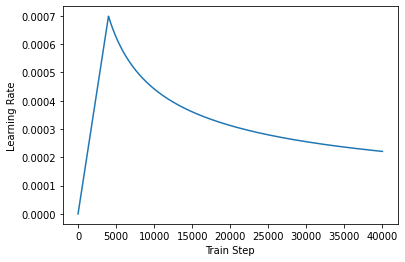

In [ ]:
temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
# Loss and metrics
loss_object = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)


In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.mean_absolute_error()

test_loss = tf.keras.metrics.Mean(name='test_loss')

In [ ]:
# Training and checkpoint
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          out_dim=1, rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    inp = inp.reshape()
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
  
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
  
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
# check point
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')
    

Latest checkpoint restored!!


In [ ]:
# EPOCHS
EPOCHS=100

In [ ]:
@tf.function
def train_step(inp, tar):
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
  
    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    #print(enc_padding_mask)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    #train_accuracy(tar_real, predictions)

In [ ]:
@tf.function
def test_step(inp, tar):
    #print(inp)
    #print(tar)
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    #print(last_inp)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     False, 
                                     None, 
                                     look_ahead_mask, 
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    test_loss(loss)

In [ ]:
# Val_dataset을 돌려서 Val_prediction 구간을 예측한다

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
    
    # validation:
    for (batch, (inp, tar)) in enumerate(val_dataset):
        #print(inp, tar)
        test_step(inp, tar)
        
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    #print ('Epoch {} Train Loss {:.4f}'.format(epoch + 1, 
                                                #train_loss.result())) 
                                                #train_accuracy.result()))
    print ('Epoch {} Test Loss {:.4f}'.format(epoch + 1, 
                                                test_loss.result())) 
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    


Epoch 1 Test Loss 0.2381
Time taken for 1 epoch: 2.471926212310791 secs

Epoch 2 Test Loss 0.2348
Time taken for 1 epoch: 0.03337359428405762 secs

Epoch 3 Test Loss 0.2308
Time taken for 1 epoch: 0.032939910888671875 secs

Epoch 4 Test Loss 0.2254
Time taken for 1 epoch: 0.032286882400512695 secs

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-21
Epoch 5 Test Loss 0.2203
Time taken for 1 epoch: 0.1207880973815918 secs

Epoch 6 Test Loss 0.2159
Time taken for 1 epoch: 0.03108811378479004 secs

Epoch 7 Test Loss 0.2112
Time taken for 1 epoch: 0.03193926811218262 secs

Epoch 8 Test Loss 0.2062
Time taken for 1 epoch: 0.029760360717773438 secs

Epoch 9 Test Loss 0.2020
Time taken for 1 epoch: 0.03214216232299805 secs

Saving checkpoint for epoch 10 at ./checkpoints/train/ckpt-22
Epoch 10 Test Loss 0.1979
Time taken for 1 epoch: 0.12577176094055176 secs

Epoch 11 Test Loss 0.1939
Time taken for 1 epoch: 0.03139543533325195 secs

Epoch 12 Test Loss 0.1888
Time taken for 1 epoch: 

In [ ]:
MAX_LENGTH = target_sequence_length

def evaluate(inp):
    encoder_input = inp
    #print(encoder_input)
    output = tf.expand_dims(encoder_input[:,-1,:],-1)
    #print(output)
    
    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        predictions, attention_weights = transformer(encoder_input, 
                                                     output, 
                                                     False, 
                                                     None, 
                                                     look_ahead_mask, 
                                                     None)
        
        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1)
        #print("pred:", predictions) #
        output = tf.concat([output, predictions], axis=1)
        #print(output)
        
    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def mape(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

In [ ]:
def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
encode_series = encoder_input_val_data[0:1,:,:] 
#print(encode_series)

pred_series, _ = evaluate(encode_series)
pred_series = np.array([pred_series])
encode_series = encode_series.reshape(-1,1)
pred_series = pred_series.reshape(-1,1)[1:,:]   
target_series = decoder_target_val_data[0,:,:1].reshape(-1,1) 

encode_series_tail = np.concatenate([encode_series[-1000:],target_series[:1]])
x_encode = encode_series_tail.shape[0]

print(mape(pred_series[:24*4+23-23]+0.02294, target_series+0.02294))

print(MSE(target_series+0.02294, pred_series[:24*4+23-23]+0.02294))

print(MAE(target_series+0.02294, pred_series[:24*4+23-23]+0.02294))

235.48355102539062
0.2638055
0.42264405


In [ ]:
x_encode

1001

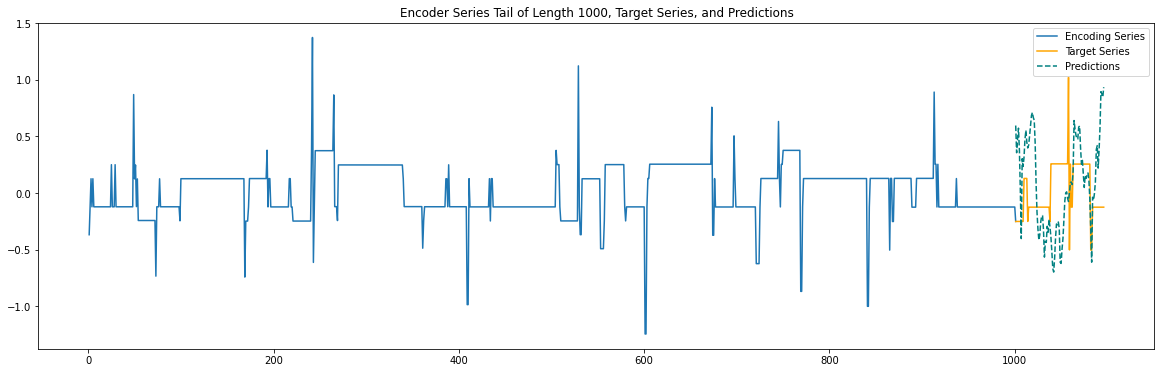

In [ ]:
# 실제와 가격차이가 어떻게 나는지 비교해서 보정한다.

plt.figure(figsize=(20,6))   

plt.plot(range(1,x_encode+1),encode_series_tail+0.02294)
plt.plot(range(x_encode,x_encode+pred_steps-23),target_series+0.02294,color='orange')
plt.plot(range(x_encode,x_encode+pred_steps-23),pred_series[:24*4+23-23]+0.02294,color='teal',linestyle='--')

plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % 1000)
plt.legend(['Encoding Series','Target Series','Predictions'])

#Prophet

In [ ]:
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')
df = df.drop(df.columns[0], axis=1)

df.columns = ["ds","y"]
df["ds"] = pd.to_datetime(df["ds"], dayfirst = True)

df.head()

,ds,y
0,2021-02-01 00:00:00,0.72904
1,2021-02-01 01:00:00,0.72904
2,2021-02-01 02:00:00,0.72904
3,2021-02-01 03:00:00,0.72904
4,2021-02-01 04:00:00,0.72904


In [ ]:
m = Prophet()
m.fit(df[:-24*4])

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(freq='H',periods=24*4)
future.tail()

,ds
4316,2021-07-30 20:00:00
4317,2021-07-30 21:00:00
4318,2021-07-30 22:00:00
4319,2021-07-30 23:00:00
4320,2021-07-31 00:00:00


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat']].tail()

,ds,yhat
4316,2021-07-30 20:00:00,0.040813
4317,2021-07-30 21:00:00,0.047362
4318,2021-07-30 22:00:00,0.049125
4319,2021-07-30 23:00:00,0.047512
4320,2021-07-31 00:00:00,0.047905


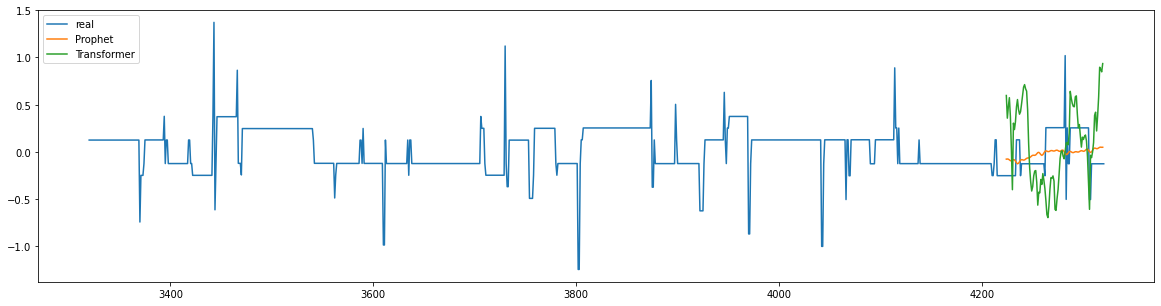

In [ ]:
plt.figure(figsize=(20,5))

plt.plot(df["y"][3320:], label="real")
plt.plot(range(4320-24*4,4320),forecast['yhat'][-24*4:], label="Prophet")
plt.plot(range(4320-24*4,4320),pred_series[:24*4+23-23]+0.02294, label="Transformer")
plt.legend()
plt.show()

#LSTMa

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tqdm import trange
import random

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

,Unnamed: 0,날짜,종가
0,0,2021-02-01 0:00,0.72904
1,1,2021-02-01 1:00,0.72904
2,2,2021-02-01 2:00,0.72904
3,3,2021-02-01 3:00,0.72904
4,4,2021-02-01 4:00,0.72904


In [ ]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
data["종가"] = min_max_scaler.fit_transform(data["종가"].to_numpy().reshape(-1,1))

In [ ]:
train = data[:-24*4]
train = train["종가"].to_numpy()

test = data[-24*4:]
test = test["종가"].to_numpy()

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

In [ ]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [ ]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)           

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)
        
        return output, self.hidden

In [ ]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [ ]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [ ]:
iw = 24*8
ow = 24*4

train_dataset = windowDataset(train, input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)
# y_train_loader = DataLoader(y_train, batch_size=5)

In [ ]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)
# model.train_model(X_train.to(device), y_train.to(device), n_epochs=100, target_len=ow, batch_size=5, training_bprediction="mixed_teacher_forcing", teacher_forcing_ratio=0.6, learning_rate=0.01, dynamic_tf=False)

In [ ]:
#5000으로 할 경우 시간도 오래걸리고 에러도 커서 100으로 줄인다.

learning_rate=0.01
epoch = 100
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

In [ ]:
from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

100%|██████████| 100/100 [09:29<00:00,  5.69s/it, loss=0.00175]


In [ ]:
predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

In [ ]:
predict = model.predict(torch.tensor(train[-24*4*2:]).reshape(-1,1).to(device).float(), target_len=ow)
real = data["종가"].to_numpy()

predict = min_max_scaler.inverse_transform(predict.reshape(-1,1))
real = min_max_scaler.inverse_transform(real.reshape(-1,1))

In [ ]:
real.shape

(4321, 1)

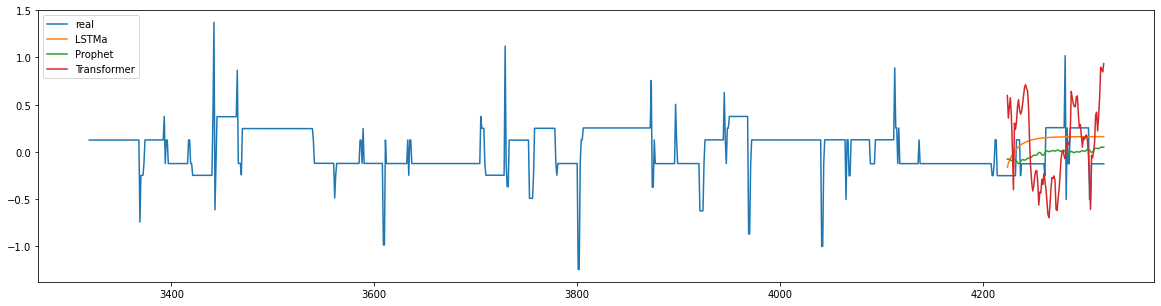

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(3319,4320), real[3320:], label="real")
plt.plot(range(4320-24*4,4320), predict[-24*4:], label="LSTMa")
plt.plot(range(4320-24*4,4320),forecast['yhat'][-24*4:], label="Prophet")
plt.plot(range(4320-24*4,4320),pred_series[:24*4+23-23]+0.02294, label="Transformer")

plt.legend()
plt.show()

#Informer

In [ ]:
!git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'Informer2020'...
remote: Enumerating objects: 535, done.
remote: Total 535 (delta 0), reused 0 (delta 0), pack-reused 535
Receiving objects: 100% (535/535), 6.47 MiB | 17.21 MiB/s, done.
Resolving deltas: 100% (306/306), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from models.model import Informer

In [ ]:
class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.
    
    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data * std) + mean
        

def time_features(dates, freq='h'):
    dates['month'] = dates.date.apply(lambda row:row.month,1)
    dates['day'] = dates.date.apply(lambda row:row.day,1)
    dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
    dates['hour'] = dates.date.apply(lambda row:row.hour,1)
    dates['minute'] = dates.date.apply(lambda row:row.minute,1)
    dates['minute'] = dates.minute.map(lambda x:x//15)
    freq_map = {
        'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
        'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
        't':['month','day','weekday','hour','minute'],
    }
    return dates[freq_map[freq.lower()]].values

def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    return outputs, batch_y

In [ ]:
class Dataset_Pred(Dataset):
    def __init__(self, dataframe, size=None, scale=True):
        self.seq_len = size[0]
        self.label_len = size[1]
        self.pred_len = size[2]
        self.dataframe = dataframe
        
        self.scale = scale
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = self.dataframe
        df_raw["date"] = pd.to_datetime(df_raw["date"])

        delta = df_raw["date"].iloc[1] - df_raw["date"].iloc[0]
        if delta>=timedelta(hours=1):
            self.freq='h'
        else:
            self.freq='t'

        

        border1 = 0
        border2 = len(df_raw)
        cols_data = df_raw.columns[1:]
        df_data = df_raw[cols_data]


        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
        else:
            data = df_data.values
            
        tmp_stamp = df_raw[['date']][border1:border2]
        tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
        pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
        
        df_stamp = pd.DataFrame(columns = ['date'])
        df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])
        data_stamp = time_features(df_stamp, freq=self.freq)

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len- self.pred_len + 1

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')

data.head()

,Unnamed: 0,날짜,종가
0,0,2021-02-01 0:00,0.72904
1,1,2021-02-01 1:00,0.72904
2,2,2021-02-01 2:00,0.72904
3,3,2021-02-01 3:00,0.72904
4,4,2021-02-01 4:00,0.72904


In [ ]:
data["date"] = data["날짜"]
data["date"] = pd.to_datetime(data["date"], dayfirst = True)
data["value"] = data["종가"]

min_max_scaler = MinMaxScaler()
data["value"] = min_max_scaler.fit_transform(data["value"].to_numpy().reshape(-1,1)).reshape(-1)
data = data[["date", "value"]]

data_train = data.iloc[:-24*4].copy()

In [ ]:
pred_len = 24*4

seq_len = pred_len#인풋 크기
label_len = pred_len#디코더에서 참고할 크기
pred_len = pred_len#예측할 크기

batch_size = 10
shuffle_flag = True
num_workers = 0
drop_last = True



dataset = Dataset_Pred(dataframe=data_train ,scale=True, size = (seq_len, label_len,pred_len))
data_loader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle_flag,num_workers=num_workers,drop_last=drop_last)

In [ ]:
enc_in = 1
dec_in = 1
c_out = 1
device = torch.device("cuda:0")

model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)
learning_rate = 1e-4
criterion =  nn.MSELoss()

model_optim = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Informer는 error를 100하는게 시간도 덜 걸리고 에러도 적다.

train_epochs = 100
model.train()
progress = tqdm(range(train_epochs))
for epoch in progress:
    train_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(data_loader):
        model_optim.zero_grad()
        pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)
        loss = criterion(pred, true)
        train_loss.append(loss.item())
        loss.backward()
        model_optim.step()
    train_loss = np.average(train_loss)
    progress.set_description("loss: {:0.6f}".format(train_loss))

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning:

Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)

loss: 0.052773: 100%|██████████| 100/100 [37:31<00:00, 22.52s/it]


In [ ]:
import time
now = time.time()
scaler = dataset.scaler
df_test = data_train.copy()
df_test["value"] = scaler.transform(df_test["value"])
df_test["date"] = pd.to_datetime(df_test["date"].values)

delta = df_test["date"][1] - df_test["date"][0]
for i in range(pred_len):
    df_test = df_test.append({"date":df_test["date"].iloc[-1]+delta}, ignore_index=True)
df_test = df_test.fillna(0)


df_test_x = df_test.iloc[-seq_len-pred_len:-pred_len].copy()
df_test_y = df_test.iloc[-label_len-pred_len:].copy()

df_test_numpy = df_test.to_numpy()[:,1:].astype("float")
test_time_x = time_features(df_test_x, freq=dataset.freq) #인풋 타임 스템프
test_data_x = df_test_numpy[-seq_len-pred_len:-pred_len] #인풋 데이터


test_time_y = time_features(df_test_y, freq=dataset.freq) #아웃풋 타임스템프
test_data_y =df_test_numpy[-label_len-pred_len:]
test_data_y[-pred_len:] = np.zeros_like(test_data_y[-pred_len:]) #예측하는 부분을 0으로 채워준다.



test_time_x = test_time_x
test_time_y = test_time_y
test_data_y = test_data_y.astype(np.float64)
test_data_x = test_data_x.astype(np.float64)

_test = [(test_data_x,test_data_y,test_time_x,test_time_y)]
_test_loader = DataLoader(_test,batch_size=1,shuffle=False)

preds = []

with torch.no_grad():
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(_test_loader):
        
        batch_x = batch_x.float().to(device)
        batch_y = batch_y.float().to(device)

        batch_x_mark = batch_x_mark.float().to(device)
        batch_y_mark = batch_y_mark.float().to(device)

        outputs = model(batch_x, batch_x_mark, batch_y, batch_y_mark)
        preds = outputs.detach().cpu().numpy()

preds = scaler.inverse_transform(preds[0])

df_test.iloc[-pred_len:, 1:] = preds
print(time.time() - now)

0.33267664909362793


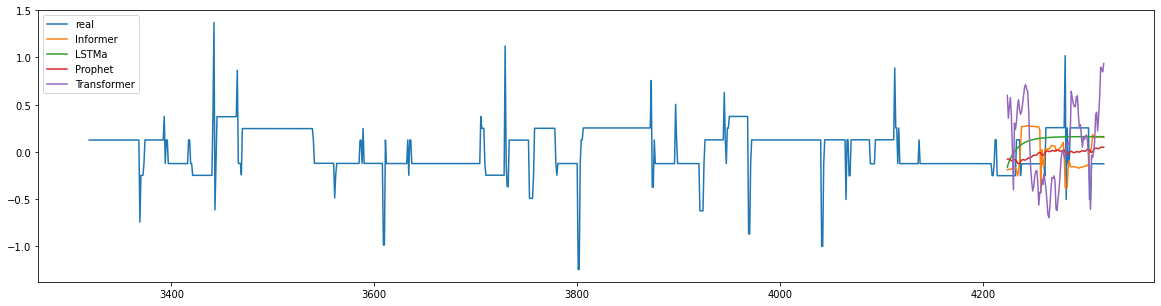

In [ ]:
import matplotlib.pyplot as plt

real = data["value"].to_numpy()
result = df_test["value"].iloc[-24*4:].to_numpy()

real = min_max_scaler.inverse_transform(real.reshape(-1,1)).reshape(-1)
result = min_max_scaler.inverse_transform(result.reshape(-1,1)).reshape(-1)

plt.figure(figsize=(20,5))
plt.plot(range(3319,4320),real[3320:], label="real")
plt.plot(range(4320-24*4,4320),result, label="Informer")
plt.plot(range(4320-24*4,4320), predict[-24*4:], label="LSTMa")
plt.plot(range(4320-24*4,4320),forecast['yhat'][-24*4:], label="Prophet")
plt.plot(range(4320-24*4,4320),pred_series[:24*4+23-23]+0.02294, label="Transformer")

plt.legend()
plt.show()


#ARIMA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/삼성전자_6M_ST_Version1.csv", encoding='CP949')
df = df.drop(df.columns[0], axis=1)
df.columns = ["ds","y"]
df.head()

,ds,y
0,2021-02-01 0:00,0.72904
1,2021-02-01 1:00,0.72904
2,2021-02-01 2:00,0.72904
3,2021-02-01 3:00,0.72904
4,2021-02-01 4:00,0.72904


In [ ]:
df_train = df.iloc[:-24*4]

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



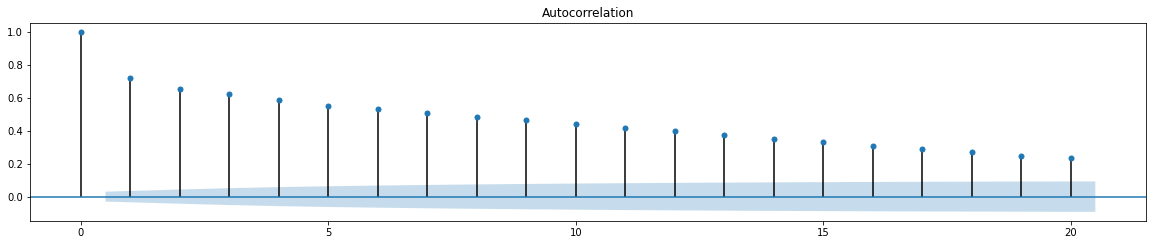

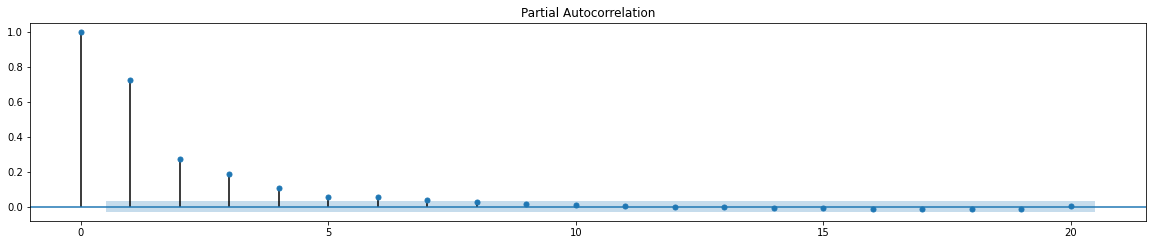

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_train["y"], lags=20, ax=ax1)

fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_train["y"], lags=20, ax=ax1)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm

In [ ]:
p = range(0,3)
d = range(1,2)
q = range(0,6)
m = 24

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1], x[2], m) for x in list(itertools.product(p,d,q))]

aic = []
params = []

with tqdm(total = len(pdq) * len(seasonal_pdq)) as pg:
    for i in pdq:
        for j in seasonal_pdq:
            pg.update(1)
            try:
                model = SARIMAX(df_train["y"], order=(i), season_order = (j))
                model_fit = model.fit()
                # print("SARIMA:{}{}, AIC:{}".format(i,j, round(model_fit.aic,2)))
                aic.append(round(model_fit.aic,2))
                params.append((i,j))
            except:
                continue

 50%|█████     | 163/324 [02:02<08:30,  3.17s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 51%|█████     | 164/324 [02:06<09:00,  3.38s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 51%|█████     | 165/324 [02:10<09:17,  3.51s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 51%|█████     | 166/324 [02:13<09:26,  3.59s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

 52%|█████▏    | 167/324 [02:17<09:38,  3.68s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likeliho

In [ ]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = SARIMAX(df_train["y"], order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 4225
Model:             SARIMAX(2, 1, 5)x(0, 1, 0, 24)   Log Likelihood               -1456.524
Date:                            Tue, 21 Sep 2021   AIC                           2929.047
Time:                                    02:27:04   BIC                           2979.790
Sample:                                         0   HQIC                          2946.990
                                           - 4225                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0425      0.047     -0.896      0.370      -0.135       0.050
ar.L2          0.8802      0.041     21.396      0.000       0.800       0.961
ma.L1         -0.5318      0.050    -10.706      0.000      -0.629      -0.434
ma.L2         -0.9945      0.069    -14.331      0.000      -1.130      -0.858
ma.L3          0.4906      0.022     22.562      0.000       0.448       0.533
ma.L4          0.0392      0.014      2.782      0.005       0.012       0.067
ma.L5         -0.0024      0.013     -0.184      0.854      -0.028       0.023
sigma2         0.1169      0.001    122.814      0.000       0.115       0.119
===================================================================================
Ljung-Box (Q):                     1026.20   Jarque-Bera (JB):            205347.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



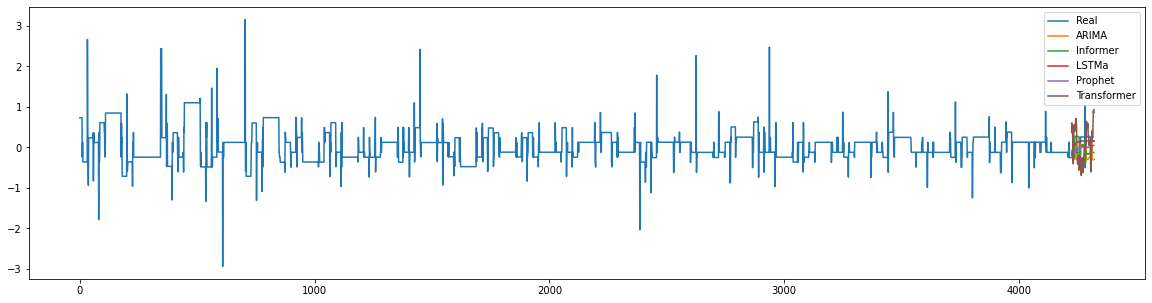

In [ ]:
model = SARIMAX(df_train["y"], order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_fit = model.fit(disp=0)
ARIMA_forecast = model_fit.forecast(steps=24*4)

plt.figure(figsize=(20,5))
plt.plot(range(0,4320), df["y"].iloc[1:], label="Real")

plt.plot(ARIMA_forecast, label="ARIMA")
plt.plot(range(4320-24*4,4320),result, label="Informer")
plt.plot(range(4320-24*4,4320), predict[-24*4:], label="LSTMa")
plt.plot(range(4320-24*4,4320),forecast['yhat'][-24*4:], label="Prophet")
plt.plot(range(4320-24*4,4320),pred_series[:24*4+23-23]+0.02294, label="Transformer")

plt.legend()
plt.show()

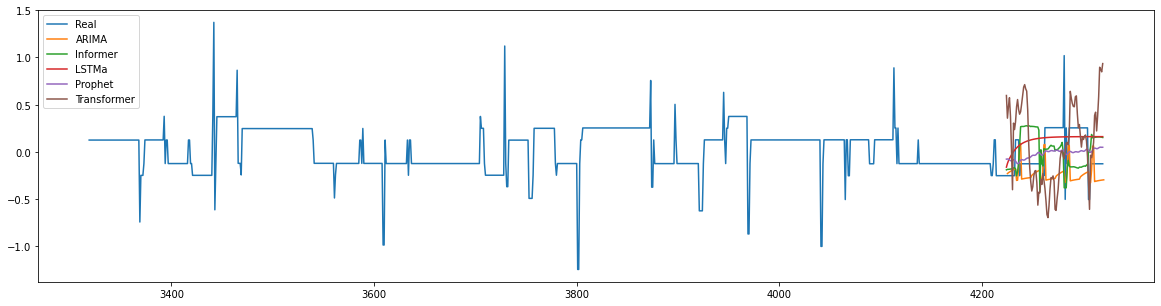

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(3319,4320), df["y"].iloc[3320:], label="Real")

plt.plot(ARIMA_forecast, label="ARIMA")
plt.plot(range(4320-24*4,4320),result, label="Informer")
plt.plot(range(4320-24*4,4320), predict[-24*4:], label="LSTMa")
plt.plot(range(4320-24*4,4320),forecast['yhat'][-24*4:], label="Prophet")
plt.plot(range(4320-24*4,4320),pred_series[:24*4+23-23]+0.02294, label="Transformer")

plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def MAPEval(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MSE(y_true, y_pred):
    return np.mean(np.square((y_true - y_pred)))

def MAE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))



print('Transformer')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(pred_series[:24*4+23-23]+0.02294, target_series+0.02294), mean_squared_error(target_series+0.02294, pred_series[:24*4+23-23]+0.02294), mean_absolute_error(target_series+0.02294, pred_series[:24*4+23-23]+0.02294)))

print('Informer')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(result, real[-24*4:]), mean_squared_error(real[-24*4:], result), mean_absolute_error(real[-24*4:], result)))

print('ARIMA')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(ARIMA_forecast, df["y"].iloc[-24*4:]), mean_squared_error(df["y"].iloc[-24*4:], ARIMA_forecast), mean_absolute_error(df["y"].iloc[-24*4:], ARIMA_forecast)))

print('Prophet')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(forecast['yhat'][4320-24*4:],df["y"][4320-24*4:]), mean_squared_error(df["y"][4320-24*4:], forecast['yhat'][4320-24*4:]), mean_absolute_error(df["y"][4320-24*4:], forecast['yhat'][4320-24*4:])))

print('LSTMa')
print('-' * 40)
print('MAPE: {} |\nMSE: {} |\nMAE : {}\n'.format(mape(predict[-24*4:],real[-24*4:]),  mean_squared_error(real[-24*4:], predict[-24*4:]), mean_absolute_error(real[-24*4:], predict[-24*4:])))

Transformer
----------------------------------------
MAPE: 235.48355102539062 |
MSE: 0.2638055086135864 |
MAE : 0.4226440489292145

Informer
----------------------------------------
MAPE: 166.0332544710088 |
MSE: 0.12189737766929427 |
MAE : 0.30415406738286016

ARIMA
----------------------------------------
MAPE: 145.55741741012432 |
MSE: 0.1456509208704508 |
MAE : 0.31226540852176815

Prophet
----------------------------------------
MAPE: 92.45123618254019 |
MSE: 0.05477051218229293 |
MAE : 0.19888744247477783

LSTMa
----------------------------------------
MAPE: 122.5556497563855 |
MSE: 0.06018275225132447 |
MAE : 0.20303428201935284

